## Notebook for experimenting with Particle EM

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import sys
sys.path.append('../code')
from plotutils import *

In [2]:
"""
Parameters and settings used to generate TAP dynamics
"""

noise_seed = np.random.randint(10000)
#noise_seed = 9662 #brain with 500 neurons
np.random.seed(noise_seed)
torch.manual_seed(noise_seed)
print('noise_seed = %d' %(noise_seed))

model_type = 1

# Ns = no. of latent variables, Nr = no. of neurons, Ny = no. of inputs
Ns, Nr, Ny = 25, 100, 25

# process and observation noise covariance matrices
q_process, q_obs = 1e-5, 5e-2
Q_process, Q_obs = q_process*np.eye(Ns), q_obs*np.eye(Nr)    


# filter used for smoothing the input signals
smoothing_filter = signal.hamming(5,sym=True) 
smoothing_filter = smoothing_filter/sum(smoothing_filter)

"""
ground truth TAP model parameters
"""
lam = np.array([0.25])  # low pass filtering constant for the TAP dynamics

G   = np.array([0,2,0,0,0,0,0,0,0,0,4,-4,0,-8,8,0,0,0]) # message passing parameters of the TAP equation

block_diagonalJ = 1
if block_diagonalJ:
    self_coupling_on, sparsity_J, gain_J, Jtype  = 1, 0, 3, 'nonferr'
    J = np.zeros([Ns,Ns])
    M = Ns//4
    J[0:M,0:M] = 1*Create_J(M, sparsity_J, 'ferr', self_coupling_on)
    J[M:2*M,M:2*M] = 1*Create_J(M, sparsity_J, 'antiferr', self_coupling_on)
    J[2*M:,2*M:] = gain_J*Create_J(Ns-2*M, 0.25, 'nonferr', self_coupling_on)
    del M
else:
    self_coupling_on, sparsity_J, gain_J, Jtype  = 1, 0.25, 3, 'nonferr' # interaction matrix settings
    J = gain_J*Create_J(Ns, sparsity_J, Jtype, self_coupling_on) # interaction matrix 

if model_type:
    gain_U = 2
    U   = gain_U*np.random.randn(Nr,Ns) # embedding matrix
else:
    gain_U = 3
    U   = gain_U*np.random.rand(Nr,Ns) # embedding matrix

if Ns <= Ny:
    V = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[2]
else:
    V = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[0]

# concatenate parameters
theta = np.concatenate([lam, G, JMatToVec(J), U.flatten('F'), V.flatten('F') ])

params = {'Ns':Ns,'Ny':Ny,'Nr':Nr,'Q_process':Q_process,'Q_obs':Q_obs,'nltype':'sigmoid','gain_y':25/np.sqrt(Ns),'smoothing_filter':smoothing_filter,'self_coupling_on':self_coupling_on,'sparsity_J':sparsity_J,'Jtype':Jtype  }

noise_seed = 4444


In [3]:
"""
Generate measurements using high gain inputs.
These measurements will be used to obtain an initial estimate of the embedding matrix.
"""
B, T = 2000, 50 
T_low, T_high = 2, 5
yG_low, yG_high = 50, 50
r_ICA = generate_TAPdynamics(theta, params, B, T, T_low, T_high, yG_low, yG_high)[2]

"""
Add baseline activity
"""

baseline = -np.min(r_ICA) if model_type else 0
r_ICA += baseline

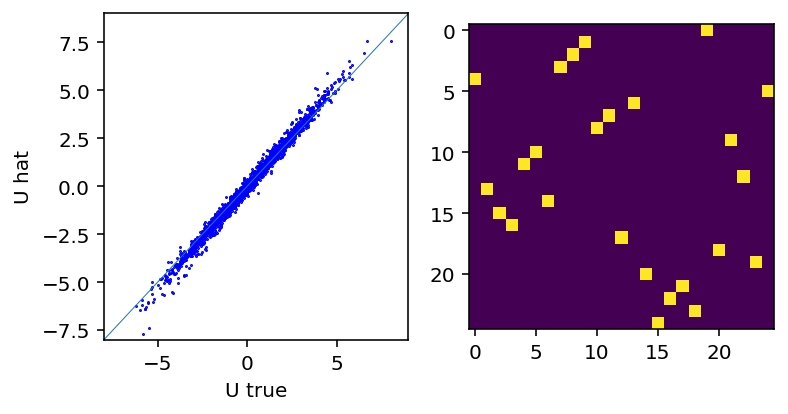

In [4]:
"""
Use ICA to get initial estimate of the embedding
"""

b_init = np.mean(r_ICA) if model_type else 0
U_init = UhatICA(np.reshape(r_ICA.transpose(1,2,0)-b_init,[Nr,T*B],order='F').T, Ns)[0]
#del r_ICA

PermMat_init = EstimatePermutation_ICA(U,U_init) # Estimate the permutation matrix P

"""
Generate random initial estimates of the parameters 
"""
G_init    = np.zeros([18])
J_init    = 0.1*Create_J(Ns, 0, params['Jtype'], params['self_coupling_on'])  # create a fully connected initial J with small initial values
if Ns <= Ny:
    V_init = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[2]
else:
    V_init = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[0]


# Plot estimate of embedding and permutation matrix
umax = np.ceil(np.max(U))
umin = np.floor(np.min(U))

fig, ax = plt.subplots(1,2,figsize=(6,3))
ax[0].plot(U.flatten(),np.dot(U_init,PermMat_init).flatten(),'b.',markersize=1)
ax[0].plot([umin,umax],[umin,umax],Linewidth=0.5)
ax[0].axis([umin,umax,umin,umax])
ax[0].set(xlabel='U true', ylabel='U hat')
ax[1].imshow(PermMat_init)
plt.show()

In [5]:
"""
Generate measurements for the particle EM algorithm
"""
B, T = 20000, 25
yG_low, yG_high = 5, 25

y, x, r_brain = generate_TAPdynamics(theta, params, B, T, T_low, T_high, yG_low, yG_high)

# Add baseline activity
baseline = -np.min(r_brain) if model_type else 0
r_brain += baseline

mean SNR = 79.3


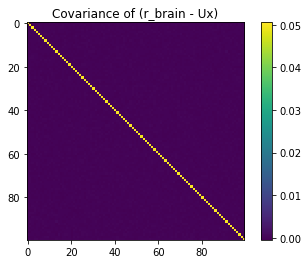

In [6]:
"""
SNR checks
"""
SNR, C_sig, C_err = computeSNR(r_brain-baseline, x, U)
print('mean SNR = %.1f' %(SNR))

plt.imshow(C_err)
plt.title('Covariance of (r_brain - Ux)')
plt.colorbar()
plt.show()

In [7]:
"""
Convert data to torch tensors
"""
device, dtype = "cpu", torch.float64

Q_process = torch.tensor(Q_process,device=device,dtype=dtype)
Q_obs     = torch.tensor(Q_obs,device=device,dtype=dtype)

P_process = Q_process.inverse()
P_obs     = Q_obs.inverse()

r_brain   = torch.tensor(r_brain,device=device,dtype=dtype)
y         = torch.tensor(y,device=device,dtype=dtype)

lam       = torch.tensor(lam,device=device,dtype=dtype,requires_grad=False)

G      = torch.tensor(G,device=device,dtype=dtype,requires_grad=False)
J      = torch.tensor(J,device=device,dtype=dtype,requires_grad=False)
U      = torch.tensor(U,device=device,dtype=dtype,requires_grad=False)
V      = torch.tensor(V,device=device,dtype=dtype,requires_grad=False)

G_hat  = torch.tensor(G_init,device=device,dtype=dtype,requires_grad=True)
U_hat  = torch.tensor(U_init,device=device,dtype=dtype,requires_grad=True)
V_hat  = torch.tensor(V_init,device=device,dtype=dtype,requires_grad=True)
J_hat_vec = torch.tensor(JMatToVec(J_init),device=device,dtype=dtype,requires_grad=True)
J_hat = JVecToMat_torch(J_hat_vec,Ns)
b_hat = torch.tensor(b_init,device=device,dtype=dtype,requires_grad=True) if model_type else 0

In [8]:
"""
Run PF with true values of parameters
""" 
Np = 100 # No. of particles to use

B_plot = 100 if B>100 else B

with torch.no_grad():
    LL_tp, x_tp, P_tp, W_tp = particlefilter(G, J, U, V, lam, r_brain[0:B_plot]-baseline, y[0:B_plot], P_process, P_obs, Np)

r_tp = torch.matmul(U,x_tp) + baseline
    
"""
Run PF with initial values of parameters
"""
t_st = time.time()
with torch.no_grad():
    LL_hat, x_hat, P_hat, W_hat = particlefilter(G_hat, J_hat, U_hat, V_hat, lam, r_brain[0:B_plot]-b_init, y[0:B_plot], P_process, P_obs, Np)
t_en = time.time()

print('time elapsed = %.2f s' %(t_en - t_st))

print('log likelihood with true parameters = %.1f' %(LL_tp.mean().data.numpy()))
print('log likelihood with initial parameters = %.1f' %(LL_hat.mean().data.numpy()))

# make a copy of the latent dynamics and fits to neural activity obtained using initial estimates of the parameters
x_init = x_hat*1.0
r_init = torch.matmul(U_hat,x_hat) + b_init

time elapsed = 9.88 s
log likelihood with true parameters = -2181.6
log likelihood with initial parameters = -120154.7


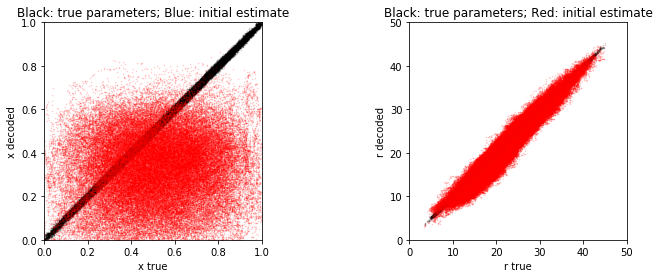

In [9]:
"""
Plot comparison of latent states decoded by the PF using initial value of parameters vs. ground truth
"""

T_st = 3 # discard the first T_st samples from each batch for comparisons

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(x[0:B_plot,:,T_st:].flatten(), x_tp[...,T_st:].data.numpy().flatten(),'k.',markersize=1,alpha=0.2)
P_temp = torch.tensor(PermMat_init.T,device=device,dtype=dtype,requires_grad=False)
ax[0].plot(x[0:B_plot,:,T_st:].flatten(), torch.matmul(P_temp, x_init[...,T_st:]).data.numpy().flatten(),'r.',markersize=1,alpha=0.2)
ax[0].set(xlabel='x true', ylabel='x decoded')
ax[0].set_title('Black: true parameters; Blue: initial estimate')
ax[0].axis('square')
ax[0].axis([0,1,0,1])

rmax = np.round(r_brain.max().item())
rmin = np.round(r_brain.min().item())

ax[1].plot(r_brain[0:B_plot,:,T_st:].data.numpy().flatten(),r_tp[...,T_st:].data.numpy().flatten(),'k.',markersize=1,alpha=0.2)
ax[1].plot(r_brain[0:B_plot,:,T_st:].data.numpy().flatten(),r_init[...,T_st:].data.numpy().flatten(),'r.',markersize=1,alpha=0.2)
ax[1].set(xlabel='r true', ylabel='r decoded')
ax[1].set_title('Black: true parameters; Red: initial estimate')
ax[1].axis('square')
ax[1].axis([rmin,rmax,rmin,rmax])

plt.show()

## run particle EM

In [11]:
lrate       = 4e-3
NIterations = 30000

if model_type:
    opt_params = [G_hat, J_hat_vec, U_hat, V_hat, b_hat]
else:
    opt_params = [G_hat, J_hat_vec, U_hat, V_hat]

optimizer  = torch.optim.Adam(opt_params,lr=lrate, betas=(0.9, 0.999))

batch_size = 3

LLVec      = [] #record the log likelihoods

t_st = time.time()

for iteration in range(NIterations):
    
    if iteration == NIterations//2:
        optimizer  = torch.optim.Adam(opt_params,lr=lrate/4, betas=(0.9, 0.999))

    if iteration == 3*NIterations//4:
        optimizer  = torch.optim.Adam(opt_params,lr=lrate/16, betas=(0.9, 0.999))
        
    
    #zero-gradients at the start of each epoch
    optimizer.zero_grad() 
    
    # select indices of batches
    idx = np.random.randint(low=0,high=B,size=batch_size)
    
    # run particle filter to get posterior for E-step
    with torch.no_grad():
        LL_b, x_b, P_b, W_b = particlefilter(G_hat, JVecToMat_torch(J_hat_vec,Ns), U_hat, V_hat, lam, r_brain[idx]-b_hat, y[idx], P_process, P_obs, Np)
        
    
    # E-step
    C = Qfunction(G_hat, JVecToMat_torch(J_hat_vec,Ns), U_hat, V_hat, lam, r_brain[idx,:,T_st:]-b_hat, y[idx,:,T_st:], P_b[...,T_st:], W_b, P_process, P_obs)
    
    # M-step
    C.backward() 
    G_hat.grad[0], G_hat.grad[9] = 0, 0 # set gradient of G0 and G9 to zero
    optimizer.step()
    
    # record the log likelihood
    LLVec.append(LL_b.mean())
    
    if (iteration+1) % 500 == 0:
        print('[%d] log likelihood: %.1f' %(iteration + 1, LL_b.mean()))
        
        

t_en = time.time()

print('Finished training')
print('Time elapsed = %.1f s'%(t_en - t_st))

In [14]:
"""
Run the PF on all the data
"""
B_plot = 100
J_hat = JVecToMat_torch(J_hat_vec,Ns)
with torch.no_grad():
    LL_hat, x_hat, P_hat, W_hat = particlefilter(G_hat, J_hat, U_hat, V_hat, lam, r_brain[0:B_plot]-b_hat, y[0:B_plot], P_process, P_obs, Np)

print('log likelihood with inferred parameters = %.1f' %(LL_hat.mean().data.numpy()))


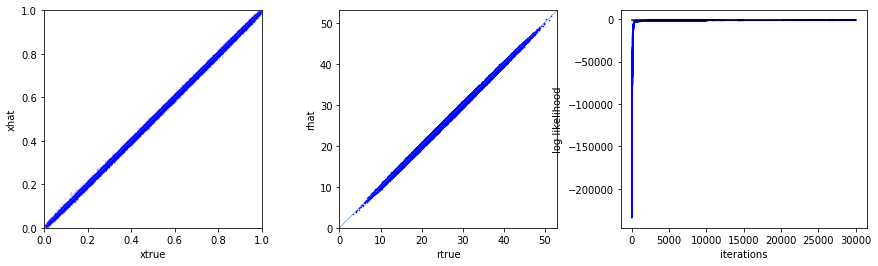

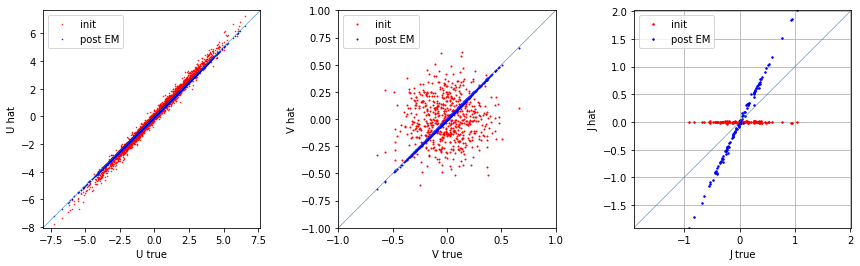

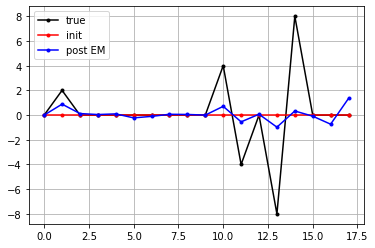

In [19]:
"""
Plotting results
"""

G_hat_ = G_hat.detach().cpu().data.numpy()
J_hat_ = J_hat.detach().cpu().data.numpy()
U_hat_ = U_hat.detach().cpu().data.numpy()
V_hat_ = V_hat.detach().cpu().data.numpy()

# Estimate PermMat again
PermMat = EstimatePermutation_ICA(U.data.numpy(),U_hat_)

# fit to neural activity
r_hat_ = (torch.matmul(U_hat,x_hat) + b_hat).data.numpy()


# figure 1
x_hat_ = x_hat.permute(1,2,0).data.numpy()
fig, ax = plt.subplots(1,3,figsize=(15,4))
P_temp = torch.tensor(PermMat.T,device=device,dtype=dtype,requires_grad=False)
ax[0].plot(x[0:B_plot,:,T_st:].flatten(), torch.matmul(P_temp, x_hat[...,T_st:]).data.numpy().flatten(),'b.',markersize=1,alpha=0.2)
ax[0].plot([0,1],[0,1],linewidth=0.5)
ax[0].set(xlabel='xtrue', ylabel='xhat')
ax[0].axis('square')
ax[0].axis([0,1,0,1])

ax[1].plot(r_brain[0:B_plot,:,T_st:].data.numpy().flatten(),r_hat_[...,T_st:].flatten(),'b.',markersize=1)
ax[1].plot([rmin,rmax],[rmin,rmax],linewidth=0.5)
ax[1].set(xlabel='rtrue', ylabel='rhat')
ax[1].axis('square')
ax[1].axis([rmin,rmax,rmin,rmax])

ax[2].plot(torch.stack(LLVec).data.numpy(),'b')
ax[2].plot([0,len(LLVec)],LL_tp.mean().item()*np.ones([2]),'k')
ax[2].set(xlabel='iterations', ylabel='log likelihood')
plt.show()

# Figure 2
Jmax = max(np.max(J.data.numpy()),np.max(J_hat_))
Jmin = min(np.min(J.data.numpy()),np.min(J_hat_))
Jhat = J_hat_*0
Jinit = J_init*0 # shuffle Jinit also
x_idx = np.dot(PermMat.T, np.arange(Ns))

for ii in range(Ns):
    for jj in range(Ns):
        Jhat[ii,jj] = J_hat_[np.int(x_idx[ii]),np.int(x_idx[jj])]
        Jinit[ii,jj] = J_init[np.int(x_idx[ii]),np.int(x_idx[jj])]
                          

fig, ax = plt.subplots(1,3,figsize=(15,4))
umax = U.max().item()
umin = U.min().item()

ax[0].plot(U.numpy().flatten(),np.dot(U_init,PermMat_init).flatten(),'r.',markersize=1)
ax[0].plot(U.numpy().flatten(),np.dot(U_hat_,PermMat).flatten(),'b.',markersize=1)
ax[0].axis('square')
ax[0].plot([umin,umax],[umin,umax],Linewidth=0.5)
ax[0].axis([umin,umax,umin,umax])
ax[0].set(xlabel='U true', ylabel='U hat')
ax[0].legend(['init', 'post EM'])

ax[1].plot(V.numpy().flatten(),np.dot(PermMat.T, V_init).flatten(),'r.',markersize=2)
ax[1].plot(V.numpy().flatten(),np.dot(PermMat.T, V_hat_).flatten(),'b.',markersize=2)
ax[1].axis('square')
ax[1].plot([-1,1],[-1,1],linewidth=0.5)
ax[1].axis([-1,1,-1,1])
ax[1].set(xlabel='V true', ylabel='V hat')
ax[1].legend(['init', 'post EM'])

ax[2].plot(JMatToVec_torch(J).numpy(),JMatToVec(Jinit),'r.',markersize=3)
ax[2].plot(JMatToVec_torch(J).numpy(),JMatToVec(Jhat),'b.',markersize=3)
ax[2].axis('square')
ax[2].plot([Jmin,Jmax],[Jmin,Jmax],linewidth=0.5)
ax[2].axis([Jmin,Jmax,Jmin,Jmax])
ax[2].set(xlabel='J true', ylabel='J hat')
ax[2].legend(['init', 'post EM'])
ax[2].grid(True)
#plt.savefig('Parameters.pdf')
plt.show()

# Plot G 
plt.plot(G.data.numpy(),'k.-')
plt.plot(G_init,'r.-')
plt.plot(G_hat_,'b.-')
plt.legend(['true','init','post EM'])
plt.grid(True)
#plt.savefig('G.pdf')
plt.show()

In [20]:
"""
Validate on new measurements
"""

B_val = 100
T_clip = 10 # burn in period, because the runTAP function starts with random initialization for x
y_val, x_val  = generate_TAPdynamics(theta, params, B_val, T+T_clip, T_low, T_high, yG_low, yG_high)[0:2]

# Run TAP dynamics using inferred theta

theta_hat = np.concatenate([np.array([lam]), G_hat_, JMatToVec(J_hat_), U_hat_.flatten('F'), V_hat_.flatten('F') ])

x_hat_val = runTAP(y_val, Q_process.data.numpy(), Q_obs.data.numpy(), theta_hat, params['nltype'])

x_val = x_val[...,T_clip:].transpose(1,2,0)
x_hat_val = x_hat_val[...,T_clip:].transpose(1,2,0)
truth = x_val.flatten()
test  = np.dot(PermMat.T, np.reshape(x_hat_val,[Ns,B_val*T])).flatten()

RMSE = 0.010


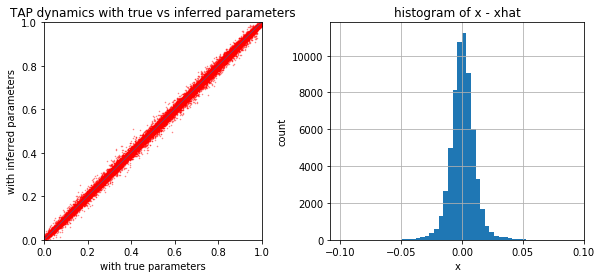

In [21]:
"""
Plot results on test set
"""

print('RMSE = %.3f' %(np.sqrt(np.mean((truth - test)**2))))

fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].plot(truth,test,'r.',markersize=1,alpha=0.5)
ax[0].plot([0,1],[0,1],linewidth=0.5)
ax[0].set(xlabel='with true parameters', ylabel='with inferred parameters', title='TAP dynamics with true vs inferred parameters')
ax[0].axis('square')
ax[0].axis([0,1,0,1])

ax[1].hist(truth-test,50)
ax[1].set(xlabel = 'x', ylabel = 'count', title = 'histogram of x - xhat')
ax[1].grid(True)
#ax[1].axis([-0.1,0.1,0,25000])
#plt.savefig('Testdata.png',dpi=300)
plt.show()

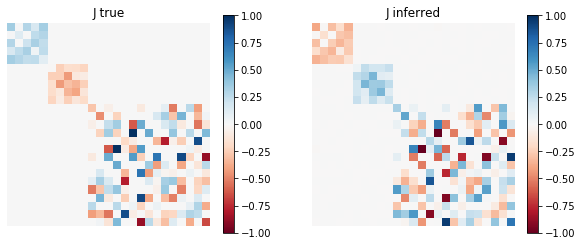

In [22]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
pcm = ax[0].imshow(J.data.numpy()/J.abs().max().item(),vmin=-1,vmax=1,cmap='RdBu')
ax[0].set(title='J true')
ax[0].axis('off')
fig.colorbar(pcm, ax=ax[0])
pcm = ax[1].imshow(-Jhat/np.max(np.abs(Jhat)),vmin=-1,vmax=1,cmap='RdBu')
ax[1].set(title='J inferred')
ax[1].axis('off')
fig.colorbar(pcm, ax=ax[1])
#plt.savefig('Jestimates.pdf')
plt.show()

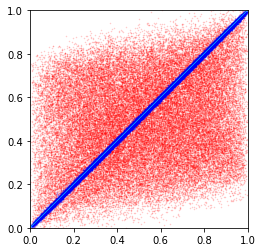

In [23]:
plt.plot(x[0:B_plot,:,T_st:].flatten(), torch.matmul(P_temp, x_init[...,T_st:]).data.numpy().flatten(),'r.',markersize=1,alpha=0.2)
plt.plot(x[0:B_plot,:,T_st:].flatten(), torch.matmul(P_temp, x_hat[...,T_st:]).data.numpy().flatten(),'b.',markersize=1,alpha=0.2)
plt.plot([0,1],[0,1],color='cyan',linewidth=0.5)
plt.axis('square')
plt.axis([0,1,0,1])
#plt.savefig('latent_dynamics.png',dpi=300)
plt.show()

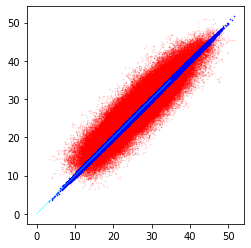

In [25]:
plt.plot(r_brain[0:B_plot,:,T_st:].data.numpy().flatten(),r_init[...,T_st:].data.numpy().flatten(),'r.',markersize=1,alpha=0.2)
plt.plot(r_brain[0:B_plot,:,T_st:].data.numpy().flatten(),r_hat_[...,T_st:].flatten(),'b.',markersize=1)
plt.plot([0,35],[0,35],color='cyan',linewidth=0.5)
plt.axis('square')
#plt.axis([0,35,0,35])
#plt.savefig('neural_dynamics.png',dpi=300)
plt.show()